In [1]:
import pandas as pd
import numpy as np
import os
import skimage
import skimage.io
import skimage.transform
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.utils import to_categorical
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
IMAGE_PATH = '../Ungrouped/32x32/Baybayin(Final Dataset)/'
IMAGE_WIDTH = 32
IMAGE_HEIGHT = 32
IMAGE_CHANNELS = 1
RANDOM_STATE = 42
TEST_SIZE = 0.2
VAL_SIZE = 0.2
CONV_2D_DIM_1 = 16
CONV_2D_DIM_2 = 16
CONV_2D_DIM_3 = 32
CONV_2D_DIM_4 = 64
MAX_POOL_DIM = 2
KERNEL_SIZE = 3
BATCH_SIZE = 32
NO_EPOCHS = 5
DROPOUT_RATIO = 0.5
PATIENCE = 5
VERBOSE = 1

In [3]:
data_df=pd.read_csv('../CSV datasets/Baybayin(Final).csv')

In [4]:
data_df.shape

(59000, 3)

In [5]:
data_df.sample(100).head()

,file,letter,label
36284,ngo_ngu (285).jpg,ngo_ngu,38
53324,we_wi (325).jpg,we_wi,54
2412,ba (413).jpg,ba,3
58195,yo_yu (196).jpg,yo_yu,59
35797,nge_ngi (798).jpg,nge_ngi,37


In [6]:
data_df

,file,letter,label
0,a (1).jpg,a,1
1,a (2).jpg,a,1
2,a (3).jpg,a,1
3,a (4).jpg,a,1
4,a (5).jpg,a,1
...,...,...,...
58995,yo_yu (996).jpg,yo_yu,59
58996,yo_yu (997).jpg,yo_yu,59
58997,yo_yu (998).jpg,yo_yu,59
58998,yo_yu (999).jpg,yo_yu,59


In [7]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data(data_df)

,Total,Percent
file,0,0.0
letter,0,0.0
label,0,0.0


In [8]:
image_files = list(os.listdir(IMAGE_PATH))
print("Number of image files: {}".format(len(image_files)))

Number of image files: 59000


In [9]:
file_names = list(data_df['file'])
print("Matching image names: {}".format(len(set(file_names).intersection(image_files))))

Matching image names: 59000


In [10]:
def read_image_sizes(file_names):
    image = skimage.io.imread(IMAGE_PATH + file_names)
    return list(image.shape)

In [11]:
m = np.stack(data_df['file'].apply(read_image_sizes))
df = pd.DataFrame(m,columns=['w','h','d'])
data_df = pd.concat([data_df,df],axis=1, sort=False)

In [12]:
data_df.head()

,file,letter,label,w,h,d
0,a (1).jpg,a,1,32,32,3
1,a (2).jpg,a,1,32,32,3
2,a (3).jpg,a,1,32,32,3
3,a (4).jpg,a,1,32,32,3
4,a (5).jpg,a,1,32,32,3


In [13]:
train_df, test_df = train_test_split(data_df, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=data_df["letter"])

In [14]:
train_df, val_df = train_test_split(train_df, test_size=VAL_SIZE, random_state=RANDOM_STATE, stratify=train_df["letter"])

In [15]:
print("Train set rows: {}".format(train_df.shape[0]))
print("Test  set rows: {}".format(test_df.shape[0]))
print("Val   set rows: {}".format(val_df.shape[0]))

Train set rows: 37760
Test  set rows: 11800
Val   set rows: 9440


In [16]:
def read_image(file_name):
    image = skimage.io.imread(IMAGE_PATH + file_name)
    image = skimage.transform.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT, 1), mode='reflect')
    return image[:,:,:]

In [17]:
def categories_encoder(dataset, var='letter'):
    X = np.stack(dataset['file'].apply(read_image))
    y = pd.get_dummies(dataset[var], drop_first=False)
    return X, y

In [18]:
def plot_images_sample(X, Y):
    # Draw plot for images sample
    
    plt.figure(figsize=(10,10))
    rand_indicies = np.random.randint(len(X), size=25)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        index = rand_indicies[i]
        plt.imshow(np.squeeze(X[index]), cmap=plt.cm.binary)
        plt.xlabel(Y[index])
    plt.show()

In [19]:
X_train, y_train = categories_encoder(train_df)
X_val, y_val = categories_encoder(val_df)
X_test, y_test = categories_encoder(test_df)

In [20]:
model=Sequential()
model.add(Conv2D(CONV_2D_DIM_1, kernel_size=KERNEL_SIZE, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS), activation='relu', padding='same'))
model.add(Conv2D(CONV_2D_DIM_2, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
model.add(MaxPool2D(MAX_POOL_DIM))
model.add(Dropout(DROPOUT_RATIO))
model.add(Conv2D(CONV_2D_DIM_2, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
model.add(Conv2D(CONV_2D_DIM_2, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
model.add(Dropout(DROPOUT_RATIO))
model.add(Flatten())
model.add(Dense(y_train.columns.size, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 16)        160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 16)        2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 16)        2320      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 16)        2320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 16)        0

In [21]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.99 ** (x+NO_EPOCHS))
earlystopper = EarlyStopping(monitor='loss', patience=PATIENCE, verbose=VERBOSE)
checkpointer = ModelCheckpoint('best_model.h5',
                                monitor='val_accuracy',
                                verbose=VERBOSE,
                                save_best_only=True,
                                save_weights_only=True)

In [22]:
train_model  = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=(X_val, y_val),
                  callbacks=[earlystopper, checkpointer, annealer])

Epoch 1/5
1180/1180 [==============================] - 8s 6ms/step - loss: 0.9296 - accuracy: 0.7504 - val_loss: 0.2994 - val_accuracy: 0.9097

Epoch 00001: val_accuracy improved from -inf to 0.90975, saving model to best_model.h5
Epoch 2/5
1180/1180 [==============================] - 7s 6ms/step - loss: 0.3115 - accuracy: 0.9083 - val_loss: 0.2051 - val_accuracy: 0.9342

Epoch 00002: val_accuracy improved from 0.90975 to 0.93422, saving model to best_model.h5
Epoch 3/5
1180/1180 [==============================] - 7s 6ms/step - loss: 0.2228 - accuracy: 0.9318 - val_loss: 0.1619 - val_accuracy: 0.9511

Epoch 00003: val_accuracy improved from 0.93422 to 0.95106, saving model to best_model.h5
Epoch 4/5
1180/1180 [==============================] - 7s 6ms/step - loss: 0.1812 - accuracy: 0.9438 - val_loss: 0.1400 - val_accuracy: 0.9595

Epoch 00004: val_accuracy improved from 0.95106 to 0.95953, saving model to best_model.h5
Epoch 5/5
1180/1180 [==============================] - 7s 6ms/step 

In [23]:
def create_trace(x,y,ylabel,color):
        trace = go.Scatter(
            x = x,y = y,
            name=ylabel,
            marker=dict(color=color),
            mode = "markers+lines",
            text=x
        )
        return trace
    
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = list(range(1,len(acc)+1))
    #define the traces
    trace_ta = create_trace(epochs,acc,"Training accuracy", "Green")
    trace_va = create_trace(epochs,val_acc,"Validation accuracy", "Red")
    trace_tl = create_trace(epochs,loss,"Training loss", "Blue")
    trace_vl = create_trace(epochs,val_loss,"Validation loss", "Magenta")
    fig = tools.make_subplots(rows=1,cols=2, subplot_titles=('Training and validation accuracy',
                                                             'Training and validation loss'))
    #add traces to the figure
    fig.append_trace(trace_ta,1,1)
    fig.append_trace(trace_va,1,1)
    fig.append_trace(trace_tl,1,2)
    fig.append_trace(trace_vl,1,2)
    #set the layout for the figure
    fig['layout']['xaxis'].update(title = 'Epoch')
    fig['layout']['xaxis2'].update(title = 'Epoch')
    fig['layout']['yaxis'].update(title = 'Accuracy', range=[0,1])
    fig['layout']['yaxis2'].update(title = 'Loss', range=[0,1])
    #plot
    iplot(fig, filename='accuracy-loss')

plot_accuracy_and_loss(train_model)

In [24]:
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.13324902951717377
Test accuracy: 0.9627118706703186


In [25]:
def test_accuracy_report(model):
    predicted = model.predict(X_test)
    test_predicted = np.argmax(predicted, axis=1)
    test_truth = np.argmax(y_test.values, axis=1)
    print(metrics.classification_report(test_truth, test_predicted, target_names=y_test.columns)) 
    test_res = model.evaluate(X_test, y_test.values, verbose=0)
    print('Loss function: %s, accuracy:' % test_res[0], test_res[1])

In [26]:
test_accuracy_report(model)

              precision    recall  f1-score   support

           a       0.94      0.84      0.89       200
           b       1.00      1.00      1.00       200
          ba       0.97      0.96      0.97       200
       be_bi       0.97      0.98      0.98       200
       bo_bu       0.99      0.98      0.99       200
         d/r       1.00      1.00      1.00       200
       da/ra       0.94      0.94      0.94       200
 de_di/re_ri       0.95      0.96      0.96       200
 do_du/ro_ru       1.00      0.94      0.97       200
         e_i       0.96      0.96      0.96       200
           g       1.00      1.00      1.00       200
          ga       0.95      0.98      0.96       200
       ge_gi       0.98      0.98      0.98       200
       go_gu       0.99      0.97      0.98       200
           h       1.00      0.99      0.99       200
          ha       0.95      0.98      0.97       200
       he_hi       0.87      0.96      0.92       200
       ho_hu       0.98    

In [27]:
model_optimal = model
model_optimal.load_weights('best_model.h5')
score = model_optimal.evaluate(X_test, y_test, verbose=0)
print(f'Best validation loss: {score[0]}, accuracy: {score[1]}')

test_accuracy_report(model_optimal)

Best validation loss: 0.13324902951717377, accuracy: 0.9627118706703186
              precision    recall  f1-score   support

           a       0.94      0.84      0.89       200
           b       1.00      1.00      1.00       200
          ba       0.97      0.96      0.97       200
       be_bi       0.97      0.98      0.98       200
       bo_bu       0.99      0.98      0.99       200
         d/r       1.00      1.00      1.00       200
       da/ra       0.94      0.94      0.94       200
 de_di/re_ri       0.95      0.96      0.96       200
 do_du/ro_ru       1.00      0.94      0.97       200
         e_i       0.96      0.96      0.96       200
           g       1.00      1.00      1.00       200
          ga       0.95      0.98      0.96       200
       ge_gi       0.98      0.98      0.98       200
       go_gu       0.99      0.97      0.98       200
           h       1.00      0.99      0.99       200
          ha       0.95      0.98      0.97       200
       he

In [34]:
from tensorflow.keras.models import load_model
saved_model = load_model('best_model.h5')
def get_predictions(X_test):
    # Digits prediction

    predictions = saved_model.predict(X_test)    
    predictions = np.argmax(predictions, axis=1)
    
    return predictions

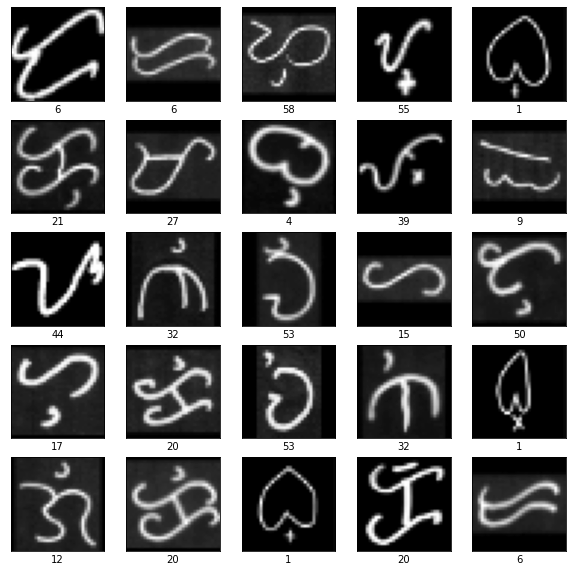

In [29]:
predictions = get_predictions(X_test)
plot_images_sample(X_test, predictions)

In [30]:
def pred_wrong_display_MNIST_dataset(X_test, predictions, y_test):
    # Displays misclassified digits from MNIST dataset
    
    X_test_wrong = []
    predictions_wrong = []
    Y_test_pred = []
    for i in range(len(X_test)):
        Y_test_pred.append(np.argmax(y_test[i]))
        if predictions[i] != Y_test_pred[i]:
            #print(i, predictions[i], Y_test_pred[i])
            X_test_wrong.append(X_test[i])
            predictions_wrong.append(predictions[i])

    plot_images_sample(X_test_wrong, predictions_wrong)
        
    print('Accuracy is', round(accuracy_score(Y_test_pred, predictions),3))
    
    return Y_test_pred

# Displays misclassified digits from MNIST
Y_test_pred = pred_wrong_display_MNIST_dataset(X_test, predictions, y_test)

In [ ]:
def plot_cm(train, target_train):
# Look at confusion matrix 
# Thanks to https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6

    def plot_confusion_matrix(cm, classes,
                              normalize=False,
                              title='Confusion matrix',
                              cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, cm[i, j],
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

    # Predict the values from the validation dataset
    Y_pred = model.predict(train)
    # Convert predictions classes to one hot vectors 
    Y_pred_classes = np.argmax(Y_pred,axis = 1) 
    # Convert validation observations to one hot vectors
    Y_true = np.argmax(target_train,axis = 1) 
    # compute the confusion matrix
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    # plot the confusion matrix
    plot_confusion_matrix(confusion_mtx, classes = range(10)) 

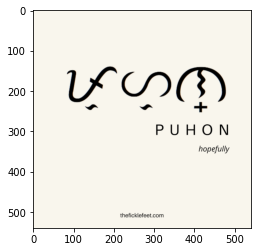

In [19]:
import cv2
image_file = 'test image.png'
image_test = cv2.imread(image_file)
plt.imshow(image_test)
plt.show()

In [20]:
def digits_finder(image_file: str, erode_kernel=48, threshold_basic=100, out_size=32):
    # Find digits on the image_file and transform it to [-1, out_size, out_size, 1]
    
    image_test = cv2.imread(image_file)
    gray_test = cv2.cvtColor(image_test, cv2.COLOR_BGR2GRAY)
    ret, thresh = cv2.threshold(gray_test, threshold_basic, 255, cv2.THRESH_BINARY)
    image_erode = cv2.erode(thresh, np.ones((erode_kernel, erode_kernel), np.uint8), iterations=1)

    # Find contours
    contours, hierarchy = cv2.findContours(image_erode, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    output = image_erode.copy()

    digits = []
    j = 0
    labels = []
    for idx, contour in enumerate(contours):
        (x, y, w, h) = cv2.boundingRect(contour)
        #if (hierarchy[0][idx][3] == 0):
        if (hierarchy[0][idx][3] == 0) and (w*h>3000):
            cv2.rectangle(output, (x, y), (x + w, y + h), (70, 0, 0), 1)
            digit_crop = image_erode[y:y + h, x:x + w]

            # Resize digit canvas to square
            size_max = max(w, h)
            print(j, w*h)
            digit_square = 255 * np.ones(shape=[size_max, size_max], dtype=np.uint8)
            if w > h:
                y_pos = size_max//2 - h//2
                digit_square[y_pos:y_pos + h, 0:w] = digit_crop
            elif w < h:
                x_pos = size_max//2 - w//2
                digit_square[0:h, x_pos:x_pos + w] = digit_crop
            else:
                digit_square = digit_crop
            
            # Resize digit to 28x28 and add digit and its X-coordinate
            digits.append((x,(cv2.resize(digit_square, (out_size, out_size), interpolation=cv2.INTER_AREA))))
            labels.append(str(j))
            j += 1
            

    # Sort array in place by X-coordinate
    digits.sort(key=lambda x: x[0], reverse=False)
    
    # Tranform digits to tensor
    digits_new =[]
    for i in range(len(digits)):
        digits_new.append(digits[i][1])
    digits_res = np.reshape(digits_new, (j, 32, 32, 1))
    digits_res = np.where(digits_res > 225, 255, digits_res)
    digits_res = np.where(digits_res < 125, 0, digits_res)

    return digits_res, labels

In [21]:
X_user_test, Y_user_test = digits_finder(image_file, erode_kernel=3, threshold_basic=100)

0 8316
1 11430
2 11776


In [22]:
def plot_images_test(X, Y):
    # Draw plot for images sample
    
    plt.figure(figsize=(10,10))
    plt.gray()
    for i in range(len(Y)):        
        plt.subplot(1,len(Y),i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(np.squeeze(X[i]))
        plt.xlabel(Y[i])
    plt.show()

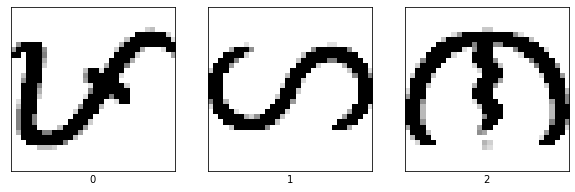

In [23]:
plot_images_test(X_user_test, Y_user_test)

In [24]:
def fe_data(df, target):
    # FE: scaling data ant transform target to categorical
    df = df / 255.
    target = to_categorical(target)
    return df, target

In [25]:
X_user_test, Y_user_test = fe_data(X_user_test, Y_user_test)

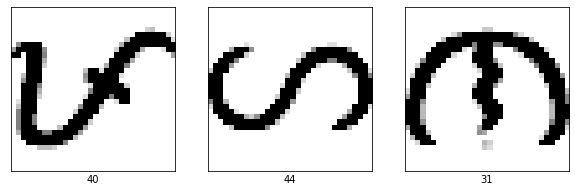

In [35]:
predictions_user = get_predictions(X_user_test)
plot_images_test(X_user_test, predictions_user)

In [45]:
# def pred_wrong_display_for_user_dataset(X_test, predictions, y_test):
#     # Displays misclassified digits from user's dataset
    
#     X_test_wrong = []
#     predictions_wrong = []
#     Y_test_pred = []
#     for i in range(len(X_test)):
#         Y_test_pred.append(np.argmax(y_test[i]))
#         if predictions[i] != Y_test_pred[i]:
#             #print(i, predictions[i], Y_test_pred[i])
#             X_test_wrong.append(X_test[i])
#             predictions_wrong.append(predictions[i])

#     plot_images_test(X_test_wrong, predictions_wrong)
        
#     print('Accuracy is', round(accuracy_score(Y_test_pred, predictions),3))
    
#     return Y_test_pred

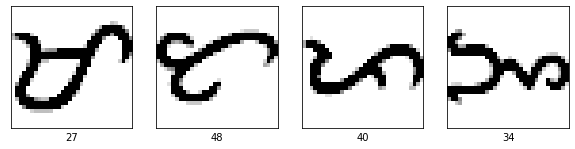

Accuracy is 0.0


In [47]:
# from sklearn.metrics import confusion_matrix, accuracy_score
# Y_user_test_pred = pred_wrong_display_for_user_dataset(X_user_test, predictions_user, Y_user_test)

In [6]:
classLabels = data_df.groupby(['letter', 'label']).size().reset_index(name='Freq')
classLabels

,letter,label,Freq
0,a,1,1000
1,b,2,1000
2,ba,3,1000
3,be_bi,4,1000
4,bo_bu,5,1000
5,d/r,6,1000
6,da/ra,7,1000
7,de_di/re_ri,8,1000
8,do_du/ro_ru,9,1000
9,e_i,10,1000
